In [14]:
hws=3 # half window size
batch_size=5 # batch size

import numpy as np
import cv2
from skimage.feature import local_binary_pattern
#from algae_core import cmap
import pickle
import os, fnmatch

#lbp
radius = 3
cmax=640
rmax=480
clmax=2
def get_image_pair(file_pair):
    """ """
    oim=cv2.imread(file_pair['raw'])#BGR
    im=cv2.resize(oim, (cmax,rmax),interpolation = cv2.INTER_CUBIC) 
       
    ocl=cv2.imread(file_pair['label'],0)
    cl=cv2.resize(ocl, (cmax,rmax),interpolation = cv2.INTER_NEAREST )
    #print cl.shape
    if cl is None:# not found
         cl=np.zeros( (im.shape[0],im.shape[1]),dtype=np.uint8 )
    
    print "raw: %s, label: %s"%(file_pair['raw'], file_pair['label'])
    
    im_grey=cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    lbp = local_binary_pattern( im_grey, 8 * radius, radius, 'uniform')
    #cv2.imshow("lbp", lbp)
    return cl,im,lbp

def get_xy(train_pairs):
    xrmax= ( (rmax-2*hws)*(cmax-2*hws)*len(train_pairs) )
    xcmax= 3+(2*hws)**2    
    x=np.zeros((xrmax,xcmax), dtype=np.uint8)
    
    yrmax= ( (rmax-2*hws)*(cmax-2*hws)*len(train_pairs) )
    y=np.zeros((yrmax), dtype=np.uint8)
    k=0
    for count,i in enumerate(train_pairs):    
        #print "------- processed %d from %d"%(count,len(train_pairs))
        cl,im,lbp=get_image_pair(i)
        #show_overlay(cl,im)
        if im.shape[0]!=rmax or im.shape[1]!=cmax or lbp.shape[0]!=rmax or lbp.shape[1]!=cmax:
            print "Error: image pair has missmatch size."
        for r in xrange(hws,lbp.shape[0]-hws):
            for c in xrange(hws,lbp.shape[1]-hws):
                xrow=np.concatenate([im[r,c],
                        lbp[r-hws:r+hws,c-hws:c+hws].reshape(1,-1)[0],])
                x[k,:]=xrow
                y[k]=cl[r,c]
                k+=1
    return x,y

In [13]:
#%reload_ext autoreload
#%autoreload 2
from algae_app.models import *
from django.db.models import Q, Sum, Count
import pandas as pd
from django.utils import timezone
from django.core.files import File
import cv2
import uuid
import numpy as np

In [3]:
import os, fnmatch
dataset_path="C:\\Users\\Wasit\\Google Drive\\Projects\\2014_algae\\dataset_2016_sept_labelled\\dataset"
os.listdir(dataset_path)

['readme.txt',
 'train_pairs.obj',
 '[160112_161737]_01.jpg',
 '[160112_161737]_01.png',
 '[160112_162212]_01.jpg',
 '[160112_162212]_01.png',
 '[160112_162212]_02.jpg',
 '[160112_162212]_02.png',
 '[160112_162212]_03.jpg',
 '[160112_162212]_03.png',
 '[160112_162212]_04.jpg',
 '[160112_162212]_04.png',
 '[160112_162212]_05.jpg',
 '[160112_162212]_05.png',
 '[160112_162212]_06.jpg',
 '[160112_162212]_06.png',
 '[160112_162212]_07.jpg',
 '[160112_162212]_07.png',
 '[160112_162212]_08.jpg',
 '[160112_162212]_08.png',
 '[160112_162212]_09.jpg',
 '[160112_162212]_09.png',
 '[160112_162212]_10.jpg',
 '[160112_162212]_10.png',
 '[160112_162212]_11.jpg',
 '[160112_162212]_11.png',
 '[160112_162212]_12.jpg',
 '[160112_162212]_12.png',
 '[160112_162212]_13.jpg',
 '[160112_162212]_13.png',
 '[160112_162212]_14.jpg',
 '[160112_162212]_14.png',
 '[160112_162212]_15.jpg',
 '[160112_162212]_15.png',
 '[160112_162212]_16.jpg',
 '[160112_162212]_16.png',
 '[160112_162212]_17.jpg',
 '[160112_162212]_17

In [15]:
raw_files=fnmatch.filter(os.listdir(dataset_path), '*.jpg')
raw_list=[i[:-4] for i in raw_files]

label_files=fnmatch.filter(os.listdir(dataset_path), '*.png')
label_list={i[:-4]:None for i in label_files}

train_pairs=[]
for count,i in enumerate(raw_list):
    if i in label_list:
        train_pairs.append({
            'raw': os.path.join(dataset_path,i)+'.jpg',
            'label': os.path.join(dataset_path,i)+'.png',
            'recall': os.path.join(dataset_path,i+"_recall")+'.jpg',
        })
        
cmap=np.array([  
    ( 0  , 255, 255,  ),
    ( 14 , 127, 255,  ),
    ( 44 , 160, 44 ,  ),
    ( 40 , 39 , 214,  ),
    ( 0  , 0  , 255,  ),
    ( 0  , 255, 0  ,  ),
    ( 194, 119, 227,  ),
    ( 255, 0  , 0  ,  ),
    ( 34 , 189, 188,  ),
    ( 207, 190, 23 ,  ),])


In [16]:
with open('forest.pic','rb') as f:
    forest = pickle.load(f)
    
for i in train_pairs[:10]:
    raw=RawImage()
    fname=i['raw']
    print fname
    raw.img.save(fname, File(open(fname, 'rb')))
    
    label=LabelImage(raw=raw)
    fname=i['label']
    label.img.save(fname, File(open(fname, 'rb')))
    
    x,y=get_xy( [i] )
    oim=cv2.imread(i['raw'])#BGR
    im=cv2.resize(oim, (cmax,rmax),interpolation = cv2.INTER_CUBIC) 
    cl_p=forest.predict( x )
    cl_p.resize((rmax-2*hws,cmax-2*hws))
    #cl_p=cv2.imread(i['label'],cv2.CV_LOAD_IMAGE_GRAYSCALE)
    ol=im.copy()
    for r in xrange(rmax-2*hws):
        for c in xrange(cmax-2*hws):
            predicting_class=cl_p[r,c]
            if predicting_class>0:
                ol[r+hws,c+hws] = cmap[ predicting_class-1 ]
    ol_rgb = cv2.cvtColor(ol, cv2.COLOR_BGR2RGB)

    temp_fname=str(uuid.uuid4())+'.jpg'
    cv2.imwrite(temp_fname, ol)
    
    recall=RecallImage(raw=raw)
    fname=i['recall']
    recall.img.save(fname, File(open(temp_fname, 'rb')))
    
    os.remove(temp_fname)

C:\Users\Wasit\Google Drive\Projects\2014_algae\dataset_2016_sept_labelled\dataset\[160112_161737]_01.jpg
raw: C:\Users\Wasit\Google Drive\Projects\2014_algae\dataset_2016_sept_labelled\dataset\[160112_161737]_01.jpg, label: C:\Users\Wasit\Google Drive\Projects\2014_algae\dataset_2016_sept_labelled\dataset\[160112_161737]_01.png


[Parallel(n_jobs=3)]: Done   1 out of   3 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.0s finished


C:\Users\Wasit\Google Drive\Projects\2014_algae\dataset_2016_sept_labelled\dataset\[160112_162212]_01.jpg
raw: C:\Users\Wasit\Google Drive\Projects\2014_algae\dataset_2016_sept_labelled\dataset\[160112_162212]_01.jpg, label: C:\Users\Wasit\Google Drive\Projects\2014_algae\dataset_2016_sept_labelled\dataset\[160112_162212]_01.png


[Parallel(n_jobs=3)]: Done   1 out of   3 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.0s finished


C:\Users\Wasit\Google Drive\Projects\2014_algae\dataset_2016_sept_labelled\dataset\[160112_162212]_02.jpg
raw: C:\Users\Wasit\Google Drive\Projects\2014_algae\dataset_2016_sept_labelled\dataset\[160112_162212]_02.jpg, label: C:\Users\Wasit\Google Drive\Projects\2014_algae\dataset_2016_sept_labelled\dataset\[160112_162212]_02.png


[Parallel(n_jobs=3)]: Done   1 out of   3 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.0s finished


C:\Users\Wasit\Google Drive\Projects\2014_algae\dataset_2016_sept_labelled\dataset\[160112_162212]_03.jpg
raw: C:\Users\Wasit\Google Drive\Projects\2014_algae\dataset_2016_sept_labelled\dataset\[160112_162212]_03.jpg, label: C:\Users\Wasit\Google Drive\Projects\2014_algae\dataset_2016_sept_labelled\dataset\[160112_162212]_03.png


[Parallel(n_jobs=3)]: Done   1 out of   3 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.0s finished


C:\Users\Wasit\Google Drive\Projects\2014_algae\dataset_2016_sept_labelled\dataset\[160112_162212]_04.jpg
raw: C:\Users\Wasit\Google Drive\Projects\2014_algae\dataset_2016_sept_labelled\dataset\[160112_162212]_04.jpg, label: C:\Users\Wasit\Google Drive\Projects\2014_algae\dataset_2016_sept_labelled\dataset\[160112_162212]_04.png


[Parallel(n_jobs=3)]: Done   1 out of   3 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.0s finished


C:\Users\Wasit\Google Drive\Projects\2014_algae\dataset_2016_sept_labelled\dataset\[160112_162212]_05.jpg
raw: C:\Users\Wasit\Google Drive\Projects\2014_algae\dataset_2016_sept_labelled\dataset\[160112_162212]_05.jpg, label: C:\Users\Wasit\Google Drive\Projects\2014_algae\dataset_2016_sept_labelled\dataset\[160112_162212]_05.png


[Parallel(n_jobs=3)]: Done   1 out of   3 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.0s finished


C:\Users\Wasit\Google Drive\Projects\2014_algae\dataset_2016_sept_labelled\dataset\[160112_162212]_06.jpg
raw: C:\Users\Wasit\Google Drive\Projects\2014_algae\dataset_2016_sept_labelled\dataset\[160112_162212]_06.jpg, label: C:\Users\Wasit\Google Drive\Projects\2014_algae\dataset_2016_sept_labelled\dataset\[160112_162212]_06.png


[Parallel(n_jobs=3)]: Done   1 out of   3 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.0s finished


C:\Users\Wasit\Google Drive\Projects\2014_algae\dataset_2016_sept_labelled\dataset\[160112_162212]_07.jpg
raw: C:\Users\Wasit\Google Drive\Projects\2014_algae\dataset_2016_sept_labelled\dataset\[160112_162212]_07.jpg, label: C:\Users\Wasit\Google Drive\Projects\2014_algae\dataset_2016_sept_labelled\dataset\[160112_162212]_07.png


[Parallel(n_jobs=3)]: Done   1 out of   3 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.0s finished


C:\Users\Wasit\Google Drive\Projects\2014_algae\dataset_2016_sept_labelled\dataset\[160112_162212]_08.jpg
raw: C:\Users\Wasit\Google Drive\Projects\2014_algae\dataset_2016_sept_labelled\dataset\[160112_162212]_08.jpg, label: C:\Users\Wasit\Google Drive\Projects\2014_algae\dataset_2016_sept_labelled\dataset\[160112_162212]_08.png


[Parallel(n_jobs=3)]: Done   1 out of   3 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.0s finished


C:\Users\Wasit\Google Drive\Projects\2014_algae\dataset_2016_sept_labelled\dataset\[160112_162212]_09.jpg
raw: C:\Users\Wasit\Google Drive\Projects\2014_algae\dataset_2016_sept_labelled\dataset\[160112_162212]_09.jpg, label: C:\Users\Wasit\Google Drive\Projects\2014_algae\dataset_2016_sept_labelled\dataset\[160112_162212]_09.png


[Parallel(n_jobs=3)]: Done   1 out of   3 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.0s finished


In [6]:
oim.shape

(1944L, 2592L, 3L)

In [7]:
im.shape

(480L, 640L, 3L)

In [8]:
cl_p.shape

(474L, 634L)

In [9]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

cmap=np.array([  
    ( 0  , 255, 255,  ),
    ( 14 , 127, 255,  ),
    ( 44 , 160, 44 ,  ),
    ( 40 , 39 , 214,  ),
    ( 0  , 0  , 255,  ),
    ( 0  , 255, 0  ,  ),
    ( 194, 119, 227,  ),
    ( 255, 0  , 0  ,  ),
    ( 34 , 189, 188,  ),
    ( 207, 190, 23 ,  ),])


Bad key "axes.spines.right" on line 210 in
C:\Anaconda\lib\site-packages\matplotlib\mpl-data\stylelib\classic.mplstyle.
You probably need to get an updated matplotlibrc file from
http://matplotlib.sf.net/_static/matplotlibrc or from the matplotlib source
distribution

Bad key "boxplot.flierprops.linewidth" on line 321 in
C:\Anaconda\lib\site-packages\matplotlib\mpl-data\stylelib\classic.mplstyle.
You probably need to get an updated matplotlibrc file from
http://matplotlib.sf.net/_static/matplotlibrc or from the matplotlib source
distribution

Bad key "contour.corner_mask" on line 306 in
C:\Anaconda\lib\site-packages\matplotlib\mpl-data\stylelib\classic.mplstyle.
You probably need to get an updated matplotlibrc file from
http://matplotlib.sf.net/_static/matplotlibrc or from the matplotlib source
distribution

Bad key "boxplot.vertical" on line 339 in
C:\Anaconda\lib\site-packages\matplotlib\mpl-data\stylelib\classic.mplstyle.
You probably need to get an updated matplotlibrc file from
h

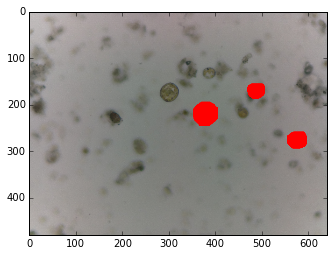

In [10]:
#dummy labelling for debug only

hws=3
cmax=640
rmax=480
oim=cv2.imread(i['raw'])#BGR
im=cv2.resize(oim, (cmax,rmax),interpolation = cv2.INTER_CUBIC) 
#cl_p=forest.predict( x )
#cl_p.resize((rmax-2*hws,cmax-2*hws))
cl_p=cv2.imread(i['label'],cv2.CV_LOAD_IMAGE_GRAYSCALE)
ol=im.copy()
for r in xrange(rmax-2*hws):
    for c in xrange(cmax-2*hws):
        predicting_class=cl_p[r,c]
        if predicting_class>0:
            ol[r+hws,c+hws] = cmap[ predicting_class-1 ]
ol_rgb = cv2.cvtColor(ol, cv2.COLOR_BGR2RGB)

temp_fname=str(uuid.uuid4())+'.jpg'
cv2.imwrite(temp_fname, ol_rgb)
os.remove(temp_fname)
plt.imshow(ol_rgb)
plt.show()


In [11]:
x=uuid.uuid4()